In [ ]:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.3.0+cu121.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 52.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 57.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 65.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 947.1/947.1 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.2 MB/s eta 0:00:00


In [ ]:
import torch
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges
from torch_geometric.data import Data
import matplotlib.pyplot as plt
import copy

/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/libpyg.so: undefined symbol: _ZN3c1010Dispatcher17runRecordFunctionERN2at14RecordFunctionESt17reference_wrapperIKNS_14FunctionSchemaEENS_11DispatchKeyE
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_clu

In [ ]:
import pandas as pd
data = pd.read_csv("omnipath.csv")

data = data.iloc[:, [1, 2, 3]]

from sklearn.preprocessing import LabelEncoder

node_encoder = LabelEncoder()

nodes = pd.concat([data['from'], data['to']]).unique()
node_encoder.fit(nodes)

data['from_encoded'] = node_encoder.transform(data['from'])
data['to_encoded'] = node_encoder.transform(data['to'])

In [ ]:
edge_index = torch.tensor([data['from_encoded'].values, data['to_encoded'].values], dtype=torch.long)
edge_attr = torch.tensor(data['sign'].values, dtype=torch.float).unsqueeze(1)  # Edge Shape: (num_edges, 1)

num_nodes = max(data['from_encoded'].max(), data['to_encoded'].max()) + 1  # Unique nodes
node_features = torch.rand((num_nodes, 32), dtype=torch.float)  # Node feature Shape: (num_nodes, 32)

# PyG Data object
data_py = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)

In [ ]:
data_py = train_test_split_edges(data_py)

Setting up Graph Variational Autoencoder:

In [ ]:
from torch_geometric.nn import VGAE

class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(VariationalGCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True) # cached only for transductive learning
        self.conv_mu = GCNConv(2 * out_channels, out_channels, cached=True)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels, cached=True)
        #The sd is typically expressed in terms of its logarithm, to ensure numerical stability and easier optimization.

    def forward(self, x, edge_index, edge_attr):
        x = self.conv1(x, edge_index, edge_weight = edge_attr).relu()
        return self.conv_mu(x, edge_index, edge_weight = edge_attr), self.conv_logstd(x, edge_index, edge_weight = edge_attr)

In [ ]:
out_channels = 16
num_features = data_py.x.shape[1]
epochs = 500

# model
model = VGAE(VariationalGCNEncoder(num_features, out_channels))


# move to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
x = data_py.x.to(device)
train_pos_edge_index = data_py.train_pos_edge_index.to(device)
val_pos_edge_index = data_py.val_pos_edge_index.to(device)
edge_attr = (data_py.train_pos_edge_attr.float() + 1) / 2  # Maps -1,1 to 0,1
train_pos_edge_attr = edge_attr.to(device)


# inizialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
def val(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index, train_pos_edge_attr)
    return model.test(z, pos_edge_index, neg_edge_index)

def test(model_best,pos_edge_index, neg_edge_index):
    model_best.eval()
    with torch.no_grad():
        z = model_best.encode(x, train_pos_edge_index, train_pos_edge_attr)
        pos_prob = model_best.decode(z, pos_edge_index)
        neg_prob = model_best.decode(z, neg_edge_index)

    return pos_prob, neg_prob

In [ ]:
def train_2():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index, train_pos_edge_attr)
    loss = model.recon_loss(z, train_pos_edge_index)

    loss = loss + (1 / data_py.num_nodes) * model.kl_loss()  # + kl divergence
    loss.backward()
    optimizer.step()
    loss2 = model.recon_loss(z, val_pos_edge_index)
    return float(loss), float(loss2)

In [ ]:
best_val_auc = 0
best_model = None

a = []
b = []
c = []
d = []

for epoch in range(1, epochs + 1):
    loss, loss2 = train_2()
    a.append(loss)
    d.append(loss2)

    # Evaluate on validation set
    val_auc, val_ap = val(data_py.val_pos_edge_index, data_py.val_neg_edge_index)
    print('Epoch: {:03d}, Loss: {:.4f}, Val AUC: {:.4f}, Val AP: {:.4f}'.format(epoch, loss, val_auc, val_ap))
    b.append(val_auc)
    c.append(val_ap)

    # Saving the best model based on validation performance and to prevent overfitting
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_model = copy.deepcopy(model)

Epoch: 001, Loss: 7.3258, Val AUC: 0.8580, Val AP: 0.8689
Epoch: 002, Loss: 4.2357, Val AUC: 0.8590, Val AP: 0.8691
Epoch: 003, Loss: 3.0074, Val AUC: 0.8573, Val AP: 0.8655
Epoch: 004, Loss: 2.5392, Val AUC: 0.8498, Val AP: 0.8556
Epoch: 005, Loss: 2.3346, Val AUC: 0.8480, Val AP: 0.8536
Epoch: 006, Loss: 2.2094, Val AUC: 0.8490, Val AP: 0.8559
Epoch: 007, Loss: 2.0378, Val AUC: 0.8503, Val AP: 0.8577
Epoch: 008, Loss: 1.9069, Val AUC: 0.8508, Val AP: 0.8580
Epoch: 009, Loss: 1.8262, Val AUC: 0.8509, Val AP: 0.8570
Epoch: 010, Loss: 1.6976, Val AUC: 0.8525, Val AP: 0.8574
Epoch: 011, Loss: 1.6252, Val AUC: 0.8567, Val AP: 0.8609
Epoch: 012, Loss: 1.5555, Val AUC: 0.8615, Val AP: 0.8655
Epoch: 013, Loss: 1.5056, Val AUC: 0.8634, Val AP: 0.8674
Epoch: 014, Loss: 1.4707, Val AUC: 0.8639, Val AP: 0.8682
Epoch: 015, Loss: 1.4383, Val AUC: 0.8639, Val AP: 0.8684
Epoch: 016, Loss: 1.4193, Val AUC: 0.8634, Val AP: 0.8678
Epoch: 017, Loss: 1.3923, Val AUC: 0.8622, Val AP: 0.8662
Epoch: 018, Lo

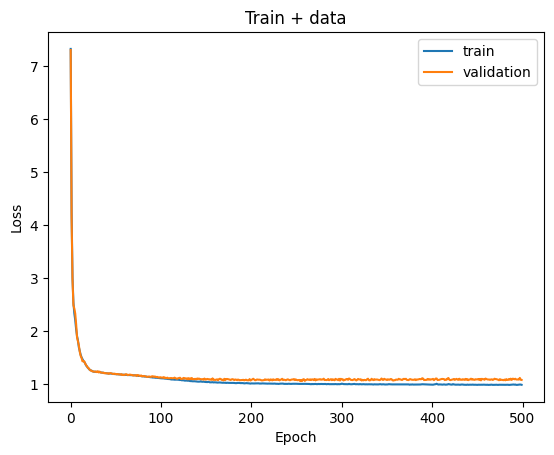

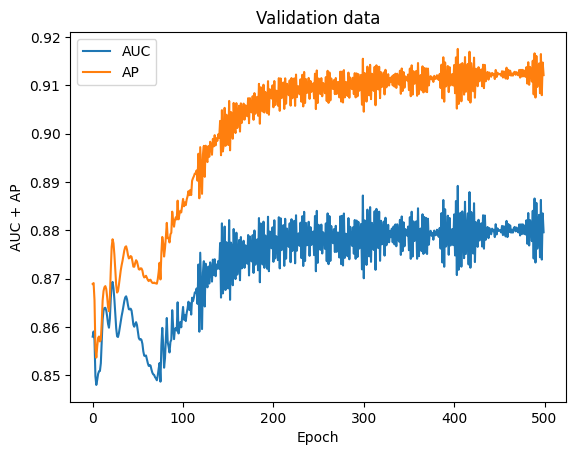

In [ ]:
plt.plot(a)
plt.plot(d)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train","validation"])
plt.title("Train + data")
plt.show()

plt.plot(b)
plt.plot(c)
plt.xlabel("Epoch")
plt.ylabel("AUC + AP")
plt.title("Validation data")
plt.legend(["AUC","AP"])
plt.show()

In [ ]:
model_1 = best_model
pos_1, neg_1 = test(model_1,data_py.test_pos_edge_index, data_py.test_neg_edge_index)

In [ ]:
percentage = ((pos_1 >= 0.7).sum() / 4366) * 100
print(f"{percentage.item():.2f}% links predicted correctly")

79.45% links predicted correctly


Setting up Bayesian Optimization for VGAE

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.0 MB/s eta 0:00:00


In [ ]:
import optuna
from tqdm import tqdm

class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels, num_layers):
        super(VariationalGCNEncoder, self).__init__()
        self.layers = torch.nn.ModuleList()
        self.layers.append(GCNConv(in_channels, 2 * out_channels, cached=True))

        for _ in range(num_layers - 2):
            self.layers.append(GCNConv(2 * out_channels, 2 * out_channels, cached=True))

        self.conv_mu = GCNConv(2 * out_channels, out_channels, cached=True)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index, edge_attr):
        for layer in self.layers:
            x = layer(x, edge_index, edge_attr).relu()
        return self.conv_mu(x, edge_index, edge_attr), self.conv_logstd(x, edge_index, edge_attr)


def objective(trial):
    # Define hyperparameters to tune
    num_layers = trial.suggest_int('num_layers', 2, 5)  # Number of GCN layers
    out_channels = trial.suggest_int('out_channels', 8, 64)  # Latent dimension
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)  # Learning rate
    node_feature_dim = trial.suggest_categorical('node_feature_dim', [16, 32, 64, 128]) #node feature dimension

    num_nodes = max(data['from_encoded'].max(), data['to_encoded'].max()) + 1
    node_features = torch.rand((num_nodes, node_feature_dim), dtype=torch.float)

    # PyG Data object
    data_py = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)
    data_py = train_test_split_edges(data_py)

    # model
    model = VGAE(VariationalGCNEncoder(node_feature_dim, out_channels, num_layers))

    # move to GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    x = data_py.x.to(device)
    train_pos_edge_index = data_py.train_pos_edge_index.to(device)
    val_pos_edge_index = data_py.val_pos_edge_index.to(device)
    edge_attr_0 = (data_py.train_pos_edge_attr.float() + 1) / 2  # Maps -1,1 to 0,1
    train_pos_edge_attr = edge_attr_0.to(device)

    # Initialize optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_auc = 0


    for epoch in tqdm(range(300), desc=f"Trial {trial.number + 1} Progress", leave=False):
            loss, loss2 = train_2()

            # Evaluate on validation set
            val_auc, val_ap = val(data_py.val_pos_edge_index, data_py.val_neg_edge_index)

            if val_auc > best_val_auc:
              best_val_auc = val_auc


    return best_val_auc  # Objective to maximize


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best parameters and best value
print("Best hyperparameters:", study.best_params)
print("Best validation AUC:", study.best_value)

Best hyperparameters: {'num_layers': 3, 'out_channels': 42, 'lr': 0.009936477241185999, 'node_feature_dim': 32}

Best validation AUC: 0.9192401871035691


Testing the best parameters found:

In [ ]:
class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(VariationalGCNEncoder, self).__init__()

        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv2 = GCNConv(2 * out_channels, 2 * out_channels, cached=True)
        self.conv_mu = GCNConv(2 * out_channels, out_channels, cached=True)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index, edge_attr):

        x = self.conv1(x, edge_index, edge_attr).relu()
        x = self.conv2(x, edge_index, edge_attr).relu()
        return self.conv_mu(x, edge_index, edge_attr), self.conv_logstd(x, edge_index, edge_attr)


out_channels = 42
num_features = data_py.x.shape[1]
epochs = 300

# model
model = VGAE(VariationalGCNEncoder(num_features, out_channels))


# move to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
x = data_py.x.to(device)
train_pos_edge_index = data_py.train_pos_edge_index.to(device)
val_pos_edge_index = data_py.val_pos_edge_index.to(device)
edge_attr_0 = (data_py.train_pos_edge_attr.float() + 1) / 2  # Maps -1,1 to 0,1
train_pos_edge_attr = edge_attr_0.to(device)


# inizialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.009936477241185999)


best_val_auc = 0
best_model = None

a = []
b = []
c = []
d = []

for epoch in range(300):
    loss, loss2 = train_2()
    a.append(loss)
    d.append(loss2)

    # Evaluate on validation set
    val_auc, val_ap = val(data_py.val_pos_edge_index, data_py.val_neg_edge_index)
    print('Epoch: {:03d}, Loss: {:.4f}, Val AUC: {:.4f}, Val AP: {:.4f}'.format(epoch, loss, val_auc, val_ap))
    b.append(val_auc)
    c.append(val_ap)

    # Saving the best model based on validation performance and to prevent overfitting
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_model = copy.deepcopy(model)

Epoch: 000, Loss: 7.7362, Val AUC: 0.8784, Val AP: 0.8860
Epoch: 001, Loss: 4.7403, Val AUC: 0.8731, Val AP: 0.8816
Epoch: 002, Loss: 3.6681, Val AUC: 0.8744, Val AP: 0.8834
Epoch: 003, Loss: 3.0567, Val AUC: 0.8725, Val AP: 0.8817
Epoch: 004, Loss: 2.4885, Val AUC: 0.8757, Val AP: 0.8846
Epoch: 005, Loss: 1.9920, Val AUC: 0.8742, Val AP: 0.8824
Epoch: 006, Loss: 1.6141, Val AUC: 0.8760, Val AP: 0.8839
Epoch: 007, Loss: 1.4358, Val AUC: 0.8777, Val AP: 0.8857
Epoch: 008, Loss: 1.3551, Val AUC: 0.8788, Val AP: 0.8871
Epoch: 009, Loss: 1.3313, Val AUC: 0.8777, Val AP: 0.8861
Epoch: 010, Loss: 1.2769, Val AUC: 0.8779, Val AP: 0.8865
Epoch: 011, Loss: 1.2816, Val AUC: 0.8734, Val AP: 0.8824
Epoch: 012, Loss: 1.2544, Val AUC: 0.8751, Val AP: 0.8843
Epoch: 013, Loss: 1.2565, Val AUC: 0.8745, Val AP: 0.8835
Epoch: 014, Loss: 1.2373, Val AUC: 0.8754, Val AP: 0.8843
Epoch: 015, Loss: 1.2547, Val AUC: 0.8739, Val AP: 0.8822
Epoch: 016, Loss: 1.2367, Val AUC: 0.8765, Val AP: 0.8848
Epoch: 017, Lo

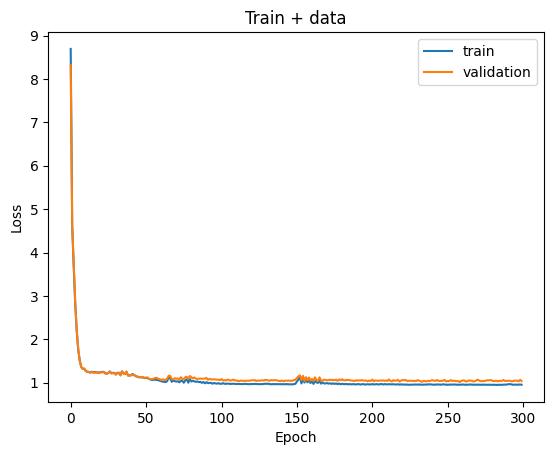

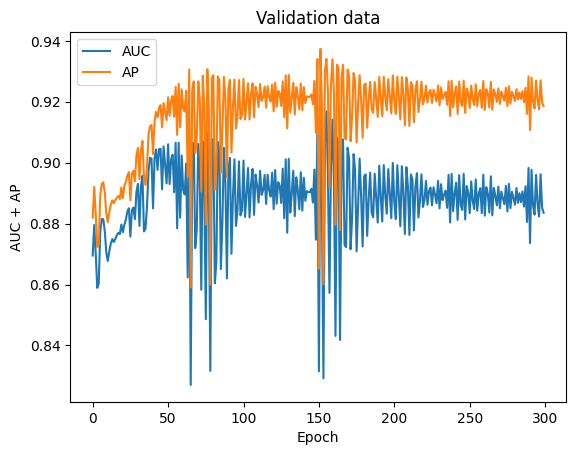

In [ ]:
plt.plot(a)
plt.plot(d)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train","validation"])
plt.title("Train + data")
plt.show()

plt.plot(b)
plt.plot(c)
plt.xlabel("Epoch")
plt.ylabel("AUC + AP")
plt.title("Validation data")
plt.legend(["AUC","AP"])
plt.show()

In [ ]:
model_2 = best_model
pos_2, neg_2 = test(model_2,data_py.test_pos_edge_index, data_py.test_neg_edge_index)

In [ ]:
percentage = ((pos_2 >= 0.7).sum() / 4366) * 100
print(f"{percentage.item():.2f}% links predicted correctly")

89.92% links predicted correctly


Now we shall add further tune this architecture by experimenting with dropout, batch normalization etc.

In [ ]:
def train_3():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index, edge_attr)
    recon_loss = model.recon_loss(z, train_pos_edge_index)

    kl_loss = (1 / data_py.num_nodes) * model.kl_loss()


    # L2 regularization
    l2_lambda = 1e-5
    l2_reg = sum(torch.sum(param ** 2) for param in model.parameters())

    # Total loss
    loss = recon_loss + kl_loss + l2_lambda * l2_reg

    loss.backward()
    optimizer.step()
    loss2 = model.recon_loss(z, val_pos_edge_index)
    return float(loss), float(loss2)

In [ ]:
class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(VariationalGCNEncoder, self).__init__()


        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.bn1 = torch.nn.BatchNorm1d(2 * out_channels) #batch normalization

        self.conv2 = GCNConv(2 * out_channels, 2 * out_channels, cached=True)
        self.bn2 = torch.nn.BatchNorm1d(2 * out_channels)
        self.conv_mu = GCNConv(2 * out_channels, out_channels, cached=True)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels, cached=True)

        #self.dropout = torch.nn.Dropout(p=0.5)


        self.act = torch.nn.ReLU()

    def forward(self, x, edge_index, edge_attr):
        x = self.conv1(x, edge_index, edge_attr)
        x = self.bn1(x)
        x = self.act(x)
        #x = self.dropout(x)

        x = self.conv2(x, edge_index, edge_attr)
        x = self.bn2(x)
        x = self.act(x)
        #x = self.dropout(x)

        return self.conv_mu(x, edge_index, edge_attr), self.conv_logstd(x, edge_index, edge_attr)


out_channels = 42
num_features = data_py.x.shape[1]
epochs = 300

# model
model = VGAE(VariationalGCNEncoder(num_features, out_channels))


# move to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
x = data_py.x.to(device)
train_pos_edge_index = data_py.train_pos_edge_index.to(device)
val_pos_edge_index = data_py.val_pos_edge_index.to(device)
edge_attr_0 = (data_py.train_pos_edge_attr.float() + 1) / 2  # Maps -1,1 to 0,1
train_pos_edge_attr = edge_attr_0.to(device)


# inizialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.009936477241185999)


best_val_auc = 0
best_model = None

a = []
b = []
c = []
d = []

for epoch in range(300):
    loss, loss2 = train_2()
    a.append(loss)
    d.append(loss2)

    # Evaluate on validation set
    val_auc, val_ap = val(data_py.val_pos_edge_index, data_py.val_neg_edge_index)
    print('Epoch: {:03d}, Loss: {:.4f}, Val AUC: {:.4f}, Val AP: {:.4f}'.format(epoch, loss, val_auc, val_ap))
    b.append(val_auc)
    c.append(val_ap)

    # Saving the best model based on validation performance and to prevent overfitting
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_model = copy.deepcopy(model)

Epoch: 000, Loss: 18.4542, Val AUC: 0.8608, Val AP: 0.8724
Epoch: 001, Loss: 11.7275, Val AUC: 0.8585, Val AP: 0.8692
Epoch: 002, Loss: 8.2967, Val AUC: 0.8598, Val AP: 0.8691
Epoch: 003, Loss: 5.4931, Val AUC: 0.8700, Val AP: 0.8790
Epoch: 004, Loss: 3.7746, Val AUC: 0.8773, Val AP: 0.8871
Epoch: 005, Loss: 2.8888, Val AUC: 0.8756, Val AP: 0.8859
Epoch: 006, Loss: 2.5414, Val AUC: 0.8738, Val AP: 0.8838
Epoch: 007, Loss: 2.2309, Val AUC: 0.8744, Val AP: 0.8842
Epoch: 008, Loss: 1.9084, Val AUC: 0.8755, Val AP: 0.8845
Epoch: 009, Loss: 1.7006, Val AUC: 0.8771, Val AP: 0.8855
Epoch: 010, Loss: 1.5719, Val AUC: 0.8805, Val AP: 0.8883
Epoch: 011, Loss: 1.4707, Val AUC: 0.8839, Val AP: 0.8916
Epoch: 012, Loss: 1.3728, Val AUC: 0.8865, Val AP: 0.8939
Epoch: 013, Loss: 1.2881, Val AUC: 0.8890, Val AP: 0.8958
Epoch: 014, Loss: 1.2199, Val AUC: 0.8914, Val AP: 0.8977
Epoch: 015, Loss: 1.1790, Val AUC: 0.8942, Val AP: 0.9000
Epoch: 016, Loss: 1.1428, Val AUC: 0.8972, Val AP: 0.9030
Epoch: 017, 

In [ ]:
model_3 = best_model
pos_3, neg_3 = test(model_3,data_py.test_pos_edge_index, data_py.test_neg_edge_index)

In [ ]:
percentage = ((pos_3 >= 0.7).sum() / 4366) * 100
print(f"{percentage.item():.2f}% links predicted correctly")

95.85% links predicted correctly


In [ ]:
(neg_3 >= 0.99).sum()

tensor(125)

For a threshold of 0.7

Batch + L-2 regularizatrion with dropout: 91.50

Batch + L-2 regularizatrion without dropout: 95.85



# **Further Analysis of the best model architecture found**

---


**How many links were not predicted and which of these links had the lowest probabilities of existence?**

In [ ]:
(pos_3 < 0.7).sum() # how many links were not predicted with the threshold of 0.7

tensor(181)

In [ ]:
sorted_probabilities = pos_3.sort()

lowest_probabilities = sorted_probabilities.values
lowest_indices = sorted_probabilities.indices

num_lowest = 10
lowest_10_values = lowest_probabilities[:num_lowest]
lowest_10_indices = lowest_indices[:num_lowest]

print(f"10 lowest probabilities: {lowest_10_values}")

10 lowest probabilities: tensor([0.0062, 0.0111, 0.0532, 0.0755, 0.1013, 0.1262, 0.1797, 0.1922, 0.1924,
        0.2272])


In [ ]:
from_node = data_py.test_pos_edge_index.cpu()[0][lowest_10_indices.cpu()]
to_node = data_py.test_pos_edge_index.cpu()[1][lowest_10_indices.cpu()]

print("from:",from_node)
print("to:",to_node)

from: tensor([1834, 1834, 2734, 1834, 1473, 4375, 5397, 2454, 3859,  786])
to: tensor([8346, 5109, 3521, 2880, 9642, 4491, 8524, 8037, 8943,  951])


**links with the lowest probabilities of existence?**

In [ ]:
from_node_name = node_encoder.inverse_transform(from_node)
to_node_name = node_encoder.inverse_transform(to_node)

for from_name, to_name in zip(from_node_name, to_node_name):
    print(f"({from_name}, {to_name})")

(CREB1, SRSF10)
(CREB1, MEGF11)
(ESR1, GRIN2D)
(CREB1, FBXL20)
(CEBPG, XDH)
(JUN, KIF18A)
(MYC, SYNGR2)
(E2F4, SLC35F6)
(HNRNPUL1, TP53)
(BABAM1, BRCA1)


**new links that had the highest probabilities of existence?**

In [ ]:
desc_sorted_probabilities = neg_3.sort(descending=True)

highest_probabilities = desc_sorted_probabilities.values
highest_indices = desc_sorted_probabilities.indices

num_highest = 10
highest_10_values = highest_probabilities[:num_highest]
highest_10_indices = highest_indices[:num_highest]

print(f"10 lowest probabilities: {highest_10_values}")

10 lowest probabilities: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])


In [ ]:
from_node_2 = data_py.test_neg_edge_index.cpu()[0][highest_10_indices.cpu()]
to_node_2 = data_py.test_neg_edge_index.cpu()[1][highest_10_indices.cpu()]

print("from:",from_node_2)
print("to:",to_node_2)

from: tensor([5991, 3062, 3050,  892, 4376,  502, 6499, 2127, 3060, 3049])
to: tensor([7191, 6069, 9500, 1522, 4524, 5219, 8943, 3056, 4940, 9194])


In [ ]:
from_node_name = node_encoder.inverse_transform(from_node_2)
to_node_name = node_encoder.inverse_transform(to_node_2)

for from_name, to_name in zip(from_node_name, to_node_name):
    print(f"({from_name}, {to_name})")

(OTX2, REL:RELB)
(FOSL2:JUND, PARP1)
(FOS:JUND, VAV2)
(BIRC6:UBA52, CETN2)
(JUN:JUNB, KIRREL2)
(AR, MMP13)
(PLXNC1, TP53)
(DCC, FOSL1:JUN)
(FOSL2:JUN, MAP3K10)
(FOS:JUNB, TXLNG)


In [ ]:
data[(data['from'] == "CREB1")& (data['to'] == "MEGF11")]

,from,to,sign,from_encoded,to_encoded
9215,CREB1,MEGF11,1,1834,5109


In [ ]:
data[(data['from'] == "OTX2") & (data['to'] == "REL:RELB")]

,from,to,sign,from_encoded,to_encoded
